In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# Afficher toutes les lignes du résultat
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
def maximimsation_marge(montant,status):
    taux_marge = 0.05
    if status == "TP":
        res = 0 # le fraudeur est détecté
    elif status == "TN":
        res = taux_marge * montant # un client honnête est accepté
    elif status == "FP":
        res = 0.7*taux_marge * montant # un client honnête est bloqué
    elif status == "FN": # un fraudeur est accepté
        if montant <= 20:
            res = 0
        elif montant <= 50:
            res = -0.2 * montant
        elif montant <= 100:
            res = -0.3 * montant
        elif montant <= 200:
            res = -0.5 * montant
        else:
            res = -0.8 * montant
    return res

In [3]:
def application_regles(y_test,y_pred):
    df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'status': "null"})
    for index, row in df.iterrows():
        if row['y_test'] == 1 and row['y_pred'] == 1:
            df.at[index, 'status'] = "TP"
        elif row['y_test'] == 0 and row['y_pred'] == 0:
            df.at[index, 'status'] = "TN"
        elif row['y_test'] == 0 and row['y_pred'] == 1:
            df.at[index, 'status'] = "FP"
        elif row['y_test'] == 1 and row['y_pred'] == 0:
            df.at[index, 'status'] = "FN"
    return df

In [4]:
method = "smote"

# ici ça ne prends pas le Cluster Code Decision
df_train = pd.read_csv("../data/dataframe_train.csv")
df_train = df_train.sample(n=100000, random_state=42)
print(df_train.shape)
df_test = pd.read_csv("../data/dataframe_test.csv")
print(df_test.shape)

(100000, 25)
(747411, 25)


In [5]:
col_to_drop = ["CodeDecision","ZIBZIN","IDAvisAutorisationCheque","Date"]

df_train = df_train.drop(columns=col_to_drop)
df_test = df_test.drop(columns=col_to_drop)

In [6]:
X_train = df_train.drop(columns=['FlagImpaye'])
X_train = X_train.values

X_test = df_test.drop(columns=['FlagImpaye'])
X_test = X_test.values


y_train = df_train['FlagImpaye']
y_train = y_train.values

y_test = df_test['FlagImpaye']
y_test = y_test.values

In [7]:
# # Turn the values into an array for feeding the classification algorithms.
# X_train = X_train.values
# X_test = X_test.values
# y_train = y_train.values
# y_test = y_test.values

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [9]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 99.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 99.0 % accuracy score
Classifiers:  SVC Has a training score of 99.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 99.0 % accuracy score


# Find best params

In [10]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l2'], 'C': [1]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_



knears_params = {"n_neighbors": [3], 'algorithm': ['auto']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_



# Support Vector Classifier
svc_params = {'C': [0.5], 'kernel': ['rbf']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
# SVC best estimator
svc = grid_svc.best_estimator_



# DecisionTree Classifier
tree_params = {"criterion": ["gini"], "max_depth": [4], 
              "min_samples_leaf": [6]}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
# tree best estimator
tree_clf = grid_tree.best_estimator_

In [11]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  99.42%
Knears Neighbors Cross Validation Score 99.4%
Support Vector Classifier Cross Validation Score 99.42%
DecisionTree Classifier Cross Validation Score 99.4%


In [12]:
from imblearn.over_sampling import SMOTE

# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy=0.1,random_state=42)

# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

In [13]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)

LogisticRegression(C=1)

<Figure size 1000x500 with 0 Axes>

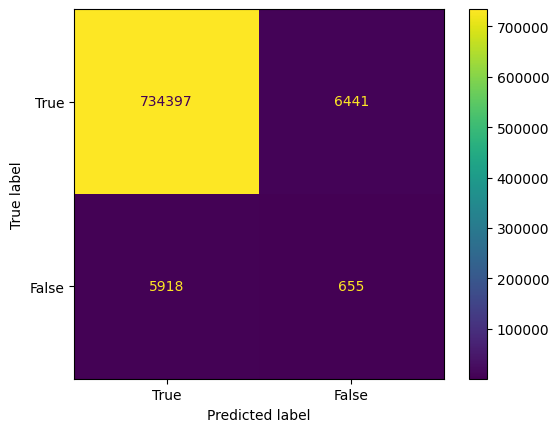

<Figure size 1000x500 with 0 Axes>

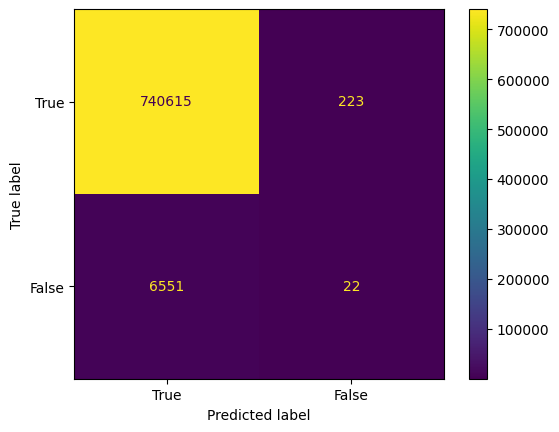

<Figure size 1000x500 with 0 Axes>

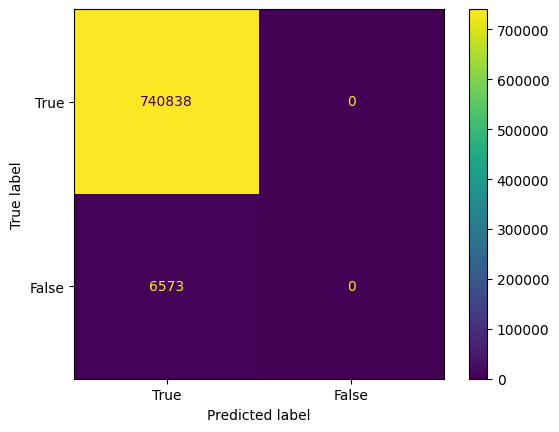

<Figure size 1000x500 with 0 Axes>

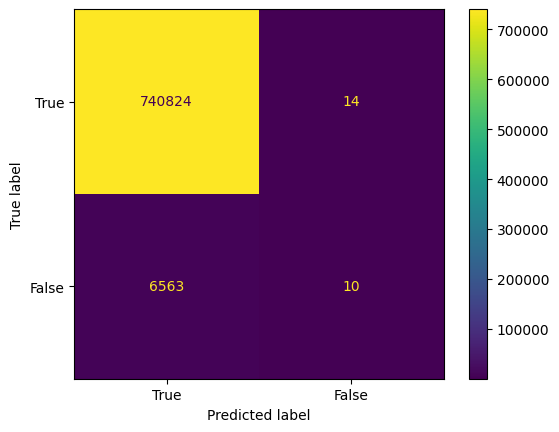

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)



from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(log_reg_cf,display_labels = [True,False])
plt.figure(figsize = (10,5))
disp.plot()


disp = ConfusionMatrixDisplay(kneighbors_cf,display_labels = [True,False])
plt.figure(figsize = (10,5))
disp.plot()

disp = ConfusionMatrixDisplay(svc_cf,display_labels = [True,False])
plt.figure(figsize = (10,5))
disp.plot()

disp = ConfusionMatrixDisplay(tree_cf,display_labels = [True,False])
plt.figure(figsize = (10,5))
disp.plot()

plt.show()